# Time Series Decomposition

The goal of this material is to introduce basic time series decomposition methods that can be applied to separate the various sub-patterns that are typically combined within time series data.  Many techniques can be used for this purpose and, as an introduction to this general topic, the computations below are aimed, first, at communicating clearly what time series decompositon is and a general approach.

We have seen this image in class previously which nicely visualizes what we will be doing.

![Cleveland Time Series Decomposition](ClevelandTimeSeriesDecomposition.jpg)

First, let's import all the packages we will need, as well as the magic command for plotting in the Jupyter notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
df = pd.read_csv('TSDataP1.csv')
df

FileNotFoundError: [Errno 2] File b'TSDataP1.csv' does not exist: b'TSDataP1.csv'

We will need a column for the Quarter index to use with computation, so let's create that now.  We will use a zero-based index. 

In [95]:
df['Quarter'] = df.index
df

,Product1Demand,Quarter
0,152400,0
1,185000,1
2,182880,2
3,161544,3
4,166116,4
5,202692,5
6,198120,6
7,176784,7
8,182880,8
9,216408,9


Let's look at the data, first, to begin to understand it.

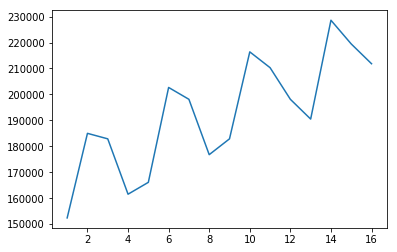

In [96]:
plt.plot(df1.Quarter,df1.Product1Demand)

Describe the pattern in this graph?  What "component patterns" do you see within the overall graph?

At this point you should observe an overall (positive) trend  and seasonality.  To perceive the trend, ask what results a linear regression analysis would yield for intercept adn slope.  Perhaps, you will intuit that the trend in this graph is a linear one rather than a nonlinear one.

You could, and should ask yourself what is causing those patterns.  You may know the causes from experience if you are familiar with the context or, alternately, you may need to do research to determine the causes.  If you were a consultant, you might well be in the latter position.

Our goal now is to decompose these data.  Doing so will enable us to forecast demand into the future because the components are easier to detect and express individually, so that we may exptrapolate them into the future.  We need to assume a functional form for how the components contribute to the overall pattern in order to guide the math that we do.  For our pruposes, we will assume this model, which is called an additive model:

- $D$ = Product Demand 
- $q$ = the index of the quarter
- $L$ = The 'level' component of the demand pattern which is a constant value
- $T$ = The (linear) trend of the data.  This is the amount that demand increases, on average, from one quarter to the next.  T is also a constant.
- $S_q$ = Seasonality component.  We need to figure out how many quarters there are before the seaonal pattern repeats so that we can determine the seasonality component for each quarter, $q$.


$D\left(q \right) = L + Tq + S_q$

We can easily get $L$and $T$ from a linear regression analysis.  We will use a new Python package for this analysis.  Many Python packages can do this analysis well.  

In [97]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Product1Demand'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 165969.76470588235     slope = 3567.764705882353      p_value =  0.0004266677252921289


Now we need to 'remove' the trend and the level from the original demand pattern to see what pattern remains for use to describe seasonality.  We use the DataFrame.apply() method from pandas for this task.

In [99]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row[1]) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format
})

,Product1Demand,Quarter,regress
0,"152,400",0,"165,970"
1,"185,000",1,"169,538"
2,"182,880",2,"173,105"
3,"161,544",3,"176,673"
4,"166,116",4,"180,241"
5,"202,692",5,"183,809"
6,"198,120",6,"187,376"
7,"176,784",7,"190,944"
8,"182,880",8,"194,512"
9,"216,408",9,"198,080"


Plot the regression line versus the original data.

In [1]:
plt.plot(df1.Quarter,df1.Product1Demand, c='k')
plt.plot(df1.Quarter,df1.regression, c='k', linestyle='--')
plt.show()

NameError: name 'plt' is not defined

In the computation below, a column is created in the DataFrame whose name is 'R1'.  The 'R' stands for remainder of the original sales trajectory after the regression 'pattern' has been extracted from the original sales pattern.

In [100]:
df['R1'] = df['Product1Demand'] - df['regress']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Product1Demand,Quarter,regress,R1
0,"152,400",0,"165,970","-13,570"
1,"185,000",1,"169,538","15,462"
2,"182,880",2,"173,105","9,775"
3,"161,544",3,"176,673","-15,129"
4,"166,116",4,"180,241","-14,125"
5,"202,692",5,"183,809","18,883"
6,"198,120",6,"187,376","10,744"
7,"176,784",7,"190,944","-14,160"
8,"182,880",8,"194,512","-11,632"
9,"216,408",9,"198,080","18,328"


Here is a plot of the R1 data column.

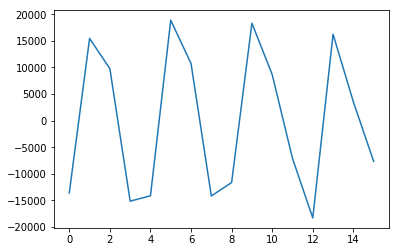

In [101]:
plt.plot(df.index,df.R1)

This looks like a repeated pattern.

How many quarters pass before the pattern repeats?

When the autocorrelation value for a particular lag is large (close to 1) and positive, it indicates a cyclic pattern with the periodicty of that lag.

In [102]:
for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))

autocorrelation, lag = 0 : 0.9999999999999999
autocorrelation, lag = 1 : -0.1102785302304146
autocorrelation, lag = 2 : -0.868909408472876
autocorrelation, lag = 3 : 0.02273671993213273
autocorrelation, lag = 4 : 0.9658506974344422
autocorrelation, lag = 5 : -0.08723019865257386
autocorrelation, lag = 6 : -0.8908995827540017
autocorrelation, lag = 7 : 0.006562427249447057


This code plots each sequential series of 4 points, where 4 corresponds with the periodicty of the data.  Note how the patterns have similar shapes, which is why the autocorrelation with this lag was nearly 1.  Let's create a graph that demonstrates this by plotting each successive group of four points.

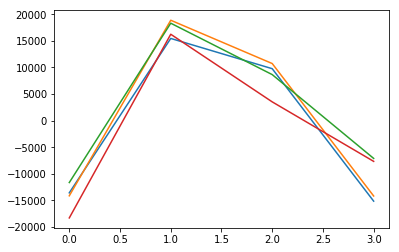

In [103]:
dfQtr = pd.DataFrame()
cycleLen = 4
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfQtr = pd.concat([dfQtr,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfQtr)

If we average the demand for each of the seasonal quarters, so those averages represent all the curves well?

              0             1             2             3           avg
0 -13569.764706 -14124.823529 -11631.882353 -18282.941176 -14402.352941
1  15462.470588  18883.411765  18328.352941  16249.294118  17230.882353
2   9774.705882  10743.647059   8664.588235   3537.529412   8180.117647
3 -15129.058824 -14160.117647  -7095.176471  -7650.235294 -11008.647059


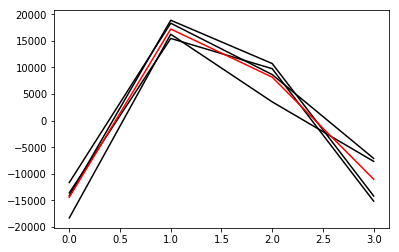

In [104]:
avg = []
for i in range(len(dfQtr.index)):
    avg.append(dfQtr.iloc[i].mean())

dfQtr = pd.concat([dfQtr,pd.DataFrame({'avg':avg})], axis=1)
print(dfQtr)

fig,ax = plt.subplots()
c = 180
for col in dfQtr.columns.values:
    if col == 'avg':
        ax.plot(dfQtr[col], c = 'r')
    else:
        ax.plot(dfQtr[col], c = 'k')

What does the remainder of the demand pattern look like if we use the average seasonality?

In [142]:
#def calcR2(row):
#    return row[3] - row[4]
    
df['S'] = np.NaN
df['error'] = np.NaN
df['R2'] = np.NaN
df['Forecast'] = np.NaN
S = dfQtr['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Forecast'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'error'] = df.loc[i,'R2'] / df.loc[i,'Product1Demand']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2': '{:,.0f}'.format,
    'Forecast':'{:,.0f}'.format,
    'error': '{:.4f}'.format
})

,Product1Demand,Quarter,regress,R1,S,R2,error,Forecast
0,"152,400",0,"165,970","-13,570","-14,402",833,0.0055,"151,567"
1,"185,000",1,"169,538","15,462","17,231","-1,768",-0.0096,"186,768"
2,"182,880",2,"173,105","9,775","8,180","1,595",0.0087,"181,285"
3,"161,544",3,"176,673","-15,129","-11,009","-4,120",-0.0255,"165,664"
4,"166,116",4,"180,241","-14,125","-14,402",278,0.0017,"165,838"
5,"202,692",5,"183,809","18,883","17,231","1,653",0.0082,"201,039"
6,"198,120",6,"187,376","10,744","8,180","2,564",0.0129,"195,556"
7,"176,784",7,"190,944","-14,160","-11,009","-3,151",-0.0178,"179,935"
8,"182,880",8,"194,512","-11,632","-14,402","2,770",0.0151,"180,110"
9,"216,408",9,"198,080","18,328","17,231","1,097",0.0051,"215,311"


Let's visualize how our model of demand fits actual product demand

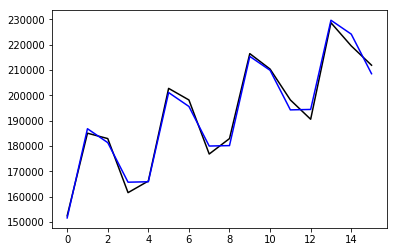

In [141]:
fig, ax = plt.subplots()
ax.plot(df['Product1Demand'],c='k')
ax.plot(df['Forecast'],c='b')

Here is a plot of the remainder, that is, the error of our model.

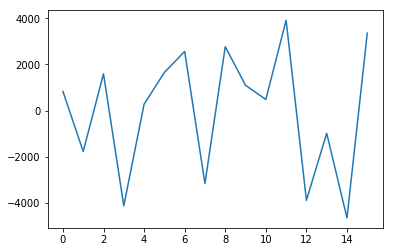

In [144]:
plt.plot(df.index,df.R2)

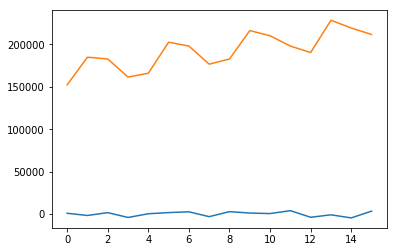

In [145]:
plt.plot(df.index,df.R2)
plt.plot(df.index,df.Product1Demand)

Here is a package that does decomposition in one step.